In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path = 'data/healthcare-dataset-stroke-data.csv'

dataframe = pd.read_csv(path)
dataframe.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Some features contain missing values that need to be imputed or otherwise handled. Additionally, certain numerical features exhibit high cardinality, which may be better represented using binning or range-based grouping. Let's perform an exploratory analysis to determine the most suitable preprocessing strategies.

Lets analyze the features that have the missing values.

In [9]:
import matplotlib

bmi = dataframe[['bmi']]
print(type(bmi))

<class 'pandas.core.frame.DataFrame'>


In [11]:
def is_not_float_or_nan(x):
    return pd.isna(x) or not isinstance(x,float)

In [29]:
#get the values that are not float type
mask = bmi.applymap(is_not_float_or_nan)
nan_count = mask.sum().item()

/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_82345/1160639344.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = bmi.applymap(is_not_float_or_nan)


In [30]:
total = len(dataframe)
not_nan_count = total - nan_count

In [31]:
print(type(nan_count), type(not_nan_count))


<class 'int'> <class 'int'>


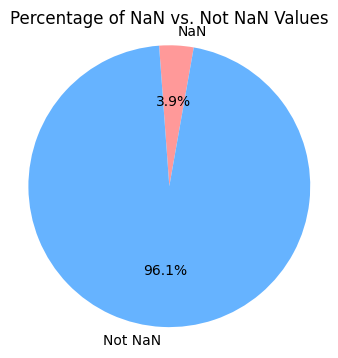

In [40]:
# Labels and percentages
labels = ['NaN', 'Not NaN']
sizes = [nan_count, not_nan_count]
colors = ['#ff9999','#66b3ff']

# Plot
plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=80)
plt.title('Percentage of NaN vs. Not NaN Values')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular.
plt.show()

As we see it's only 3.9% of the data that have missing values. So I use the techniques to fill that missing values and then apply bining to the some features of the data set, like age,bmi and average glucose level.

I binned the age feature into defined ranges and added a new column to display the age group for each entry in the dataset.

In [ ]:
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']

dataframe['age_group'] = pd.cut(dataframe['age'],bins = bins,labels = labels,right=True)


In [45]:
dataframe

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,61-80
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,61-80
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,61-80
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,41-60
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,61-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0,61-80
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0,81-100
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0,21-40
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0,41-60


By binning the age feature into defined groups, we can impute missing BMI values more effectively. The approach involves replacing a missing BMI with the average BMI of the corresponding age group. This method is likely to be more accurate than simply using the overall average BMI across the entire dataset.

For each group range calculate the bmi average value.

In [64]:
bmi_mean_by_age = dataframe.groupby('age_group')['bmi'].mean().to_dict()


/var/folders/28/pmh07v693dn2c3l0jdz5zvlw0000gn/T/ipykernel_82345/4007097876.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bmi_mean_by_age = dataframe.groupby('age_group')['bmi'].mean().to_dict()


In [66]:
bmi_mean_by_age

{'0-20': 22.203599999999998,
 '21-40': 30.001182432432433,
 '41-60': 31.6684350132626,
 '61-80': 30.07005444646098,
 '81-100': 27.988695652173913}

In [71]:
for key,val in bmi_mean_by_age.items():
    mask = (dataframe['age_group'] == key) & (dataframe['bmi'].isna())
    dataframe.loc[mask,'bmi'] = val
    
dataframe['bmi'] = dataframe['bmi'].round(2)

 What this does:

dataframe['age_group'] == key: creates a boolean Series that's True where the age_group is equal to the current key (e.g., '21-40')

dataframe['bmi'].isna(): creates another boolean Series that's True where the bmi value is missing (NaN)

The & operator combines these two conditions: only rows that match the current age group and have a missing BMI are True.

🟰 So mask is a boolean Series where only the relevant rows that need updating are True.


In [72]:
dataframe

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1,61-80
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.07,never smoked,1,61-80
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1,61-80
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.40,smokes,1,41-60
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1,61-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,30.07,never smoked,0,61-80
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.00,never smoked,0,81-100
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.60,never smoked,0,21-40
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.60,formerly smoked,0,41-60


Also we need to preproccess the data that have values like Yes/No for the ever married feature, make it binary 0/1

In [ ]:
# Encode 'Sex' column
dataframe.loc[:, 'ever_married'] = dataframe['ever_married'].map({'No': 0, 'Yes': 1})

Let's analyze the connections between , age and stroke, average glucose level and stroke, bmi amd age 

Preproccess the string values in the data set, because there some algorithms that can't handle the string type data.

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dataframe['work_type_encoded'] = le.fit_transform(dataframe['work_type'])


In [49]:
#the min value of the avg_glucose_level and bmi
#use this for the binning 

min_glucose = dataframe['avg_glucose_level'].min()
max_glucose = dataframe['avg_glucose_level'].max()

min_bmi = dataframe['bmi'].min()
max_bmi = dataframe['bmi'].max()



In [48]:
print(min_glucose,max_glucose)

55.12 271.74


In [50]:
def num_of_bins(max_val,min_val,num_intervals):
    return (max_val - min_val)/num_intervals

In [52]:
glucose_bins = num_of_bins(max_glucose,min_glucose,5)
bmi_bins = num_of_bins(max_bmi,min_bmi,5)

In [73]:
glucose_bins,bmi_bins

(43.324, 17.46)

Discovering the numbers of strokes verses non stroke cases in the data set.

In [37]:
stroke_num = dataframe[['stroke']].sum().item()
non_stroke = len(dataframe) - stroke_num

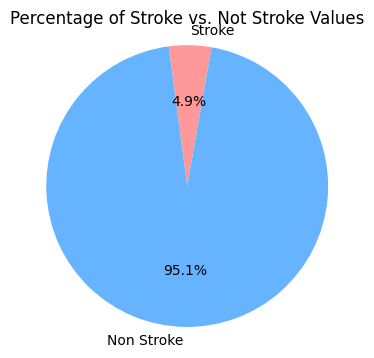

In [39]:
# Labels and percentages
labels = ['Stroke', 'Non Stroke']
sizes = [stroke_num, non_stroke]
colors = ['#ff9999','#66b3ff']

# Plot
plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=80)
plt.title('Percentage of Stroke vs. Not Stroke Values')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular.
plt.show()

We have a relatively small number of stroke cases—approximately 5% of the entire dataset. This creates a class imbalance problem, which can negatively affect the model’s ability to accurately classify stroke cases versus non-stroke cases. Due to the imbalance, the model is more likely to learn patterns from the majority class (non-stroke), leading to poor detection of stroke instances. To address this issue, I will apply specific techniques to mitigate the effects of the imbalance.

SMOTE is used to increase the representation of the minority class labels by generating synthetic samples.


Here’s how SMOTE works (simplified).

1. Randomly select some data points in the minority class.
2. For every selected point, identify its k nearest neighbour(s).
3. For every neighbor, add a new point somewhere between the data point and the neighbor.
4. Repeat steps 2 to 4 until sufficient synthetic data points are created.